In [1]:
import os
import sys
import math
import numpy as np
import ROOT

from ROOT import TCanvas, TPad, TFile
from ROOT import TGraphAsymmErrors, TH2D, TLegend
from ROOT import TMarker, TBox, TGaxis
from ROOT import kYellow, kGreen, kWhite, kBlack, kOrange

import CMS_lumi as CMS_lumi
import tdrstyle as tdrstyle

tdrstyle.setTDRStyle()
ROOT.gStyle.SetPalette(1)
# missing RooFit dictionaries, but we don't need them
ROOT.gROOT.ProcessLine('gErrorIgnoreLevel = 2001;');

Welcome to JupyROOT 6.10/08


In [2]:
# this list is ordered and ends with the combination
cats = ['cat'+str(i).zfill(2) for i in xrange(1,16)]
cats += ['comb_2jet']
cats += ['comb_01jet']
cats += ['comb_01jet_tight']
cats += ['comb_01jet_loose']
cats += ['comb_tot']
cat_names = [
    'VBF Tight (cat01)',
    '2-jet Tight (cat02)',
    '2-jet Loose (cat03)',
    '01-jet Tight BB (cat04)',
    '01-jet Tight BO (cat05)',
    '01-jet Tight BE (cat06)',
    '01-jet Tight OO (cat07)',
    '01-jet Tight OE (cat08)',
    '01-jet Tight EE (cat09)',
    '01-jet Loose BB (cat10)',
    '01-jet Loose BO (cat11)',
    '01-jet Loose BE (cat12)',
    '01-jet Loose OO (cat13)',
    '01-jet Loose OE (cat14)',
    '01-jet Loose EE (cat15)',
    '2-jet Comb.',
    '01-jet Comb.',
    '01-jet Tight Comb.',
    '01-jet Loose Comb.',
    'Total Combination',
]
assert len(cat_names) == len(cats), 'Category list/size mismatch'

In [17]:
# final plot parameters
num_bins = len(cats)
xmax = 100.
setlog = True

ymax = num_bins+0.5

blind = False

printresults = False

leg_x1, leg_y1 = 0.25, 0.41
leg_x2, leg_y2 = 0.5, 0.51

margin_bottom = 0.15
margin_left = 0.18

isprelim = True
lumipos = 0

lumi = 35920. # pb

In [4]:
# set up files
tfiles = {'comb_tot': ROOT.TFile.Open('/Users/ken/Work/PlotMaker/data/combine/higgsCombine_'
                                 'comb_tot.Asymptotic.mH125.root')}
for c in cats:
    tfiles[c] = ROOT.TFile.Open('/Users/ken/Work/PlotMaker/data/combine/higgsCombine_'
                                +c+'.Asymptotic.mH125.root')

In [5]:
# empty map to hold limits for each category
limits = { c:{} for c in cats }
# fill limit map
for c in cats:
    lt = tfiles[c].Get('limit')
    lt.GetEntry(0)
    limits[c]['2s_down'] = lt.limit
    lt.GetEntry(1)
    limits[c]['1s_down'] = lt.limit
    lt.GetEntry(2)
    limits[c]['median']  = lt.limit
    lt.GetEntry(3)
    limits[c]['1s_up']   = lt.limit
    lt.GetEntry(4)
    limits[c]['2s_up']   = lt.limit
    
    if not blind:
        lt.GetEntry(5)
        limits[c]['obs']     = lt.limit
        limits[c]['obs_err'] = lt.limitErr
    else:
        limits[c]['obs']     = -1
        limits[c]['obs_err'] = -1

# observed
vals_array_x_obs_ = []
vals_err_x_obs_   = []
# median expected
vals_array_x_ = []
# y coordinate, essentially the inverted cat number
vals_array_y_ = []
# green (1 std deviation bands)
vals_err_x_low_1s_  = []
vals_err_x_high_1s_ = []
# yellow (2 std deviation bands)
vals_err_x_low_2s_  = []
vals_err_x_high_2s_ = []

# fill arrays of rectangle coordinates which will be given to TGraph constr
for i, c in enumerate(cats):
    med = limits[c]['median']
    vals_array_x_.insert(0, med)
    vals_array_y_ += [float(i+0.5)]
    vals_err_x_low_1s_.insert(0,abs(limits[c]['1s_down'] - med))
    vals_err_x_high_1s_.insert(0, abs(limits[c]['1s_up']   - med))
    vals_err_x_low_2s_.insert(0, abs(limits[c]['2s_down'] - med))
    vals_err_x_high_2s_.insert(0, abs(limits[c]['2s_up']   - med))
    vals_array_x_obs_.insert(0, limits[c]['obs'])
    vals_err_x_obs_.insert(0, limits[c]['obs_err'])

# dummies
vals_err_y_     = [0.21] * len(cats)
vals_err_y_obs_ = [0.] * len(cats)

# turn them into arrays
vals_array_x = np.asarray(vals_array_x_)
vals_array_y = np.asarray(vals_array_y_)
vals_err_y   = np.asarray(vals_err_y_)
vals_err_y_obs     = np.asarray(vals_err_y_obs_)
vals_err_x_low_2s  = np.asarray(vals_err_x_low_2s_)
vals_err_x_high_2s = np.asarray(vals_err_x_high_2s_)
vals_err_x_low_1s  = np.asarray(vals_err_x_low_1s_)
vals_err_x_high_1s = np.asarray(vals_err_x_high_1s_)
vals_array_x_obs   = np.asarray(vals_array_x_obs_)
vals_err_x_obs     = np.asarray(vals_err_x_obs_)

In [6]:
# make canvas
canvname = 'catlims'
canvas = canvas = ROOT.TCanvas(canvname,canvname,1700,1100)
canvas.SetBottomMargin(margin_bottom)
canvas.SetLeftMargin(margin_left)
canvas.cd()
canvas.SetGrid()

In [7]:
# plot back layer - 2 sigma bands
yellow = TGraphAsymmErrors(len(cats), vals_array_x, vals_array_y, 
                           vals_err_x_low_2s, vals_err_x_high_2s, vals_err_y, vals_err_y)
yellow.SetMarkerSize(2)
yellow.SetMarkerStyle(20)
yellow.SetFillColor(kOrange)
yellow.SetLineColor(kOrange)
yellow.SetFillStyle(1001)

# plot front layer - 1 sigma bands and median
green = TGraphAsymmErrors(len(cats), vals_array_x, vals_array_y,
                          vals_err_x_low_1s, vals_err_x_high_1s, vals_err_y, vals_err_y)
green.SetMarkerSize(2)
green.SetMarkerStyle(5)
green.SetFillColor(kGreen+1)
green.SetLineColor(kGreen+1)
green.SetFillStyle(1001)

# plot observed
money = TGraphAsymmErrors(len(cats), vals_array_x_obs, vals_array_y,
                          vals_err_x_obs, vals_err_x_obs, vals_err_y_obs, vals_err_y_obs)
money.SetMarkerSize(1)
money.SetMarkerStyle(20)

35.9 fb^{-1} (13 TeV)


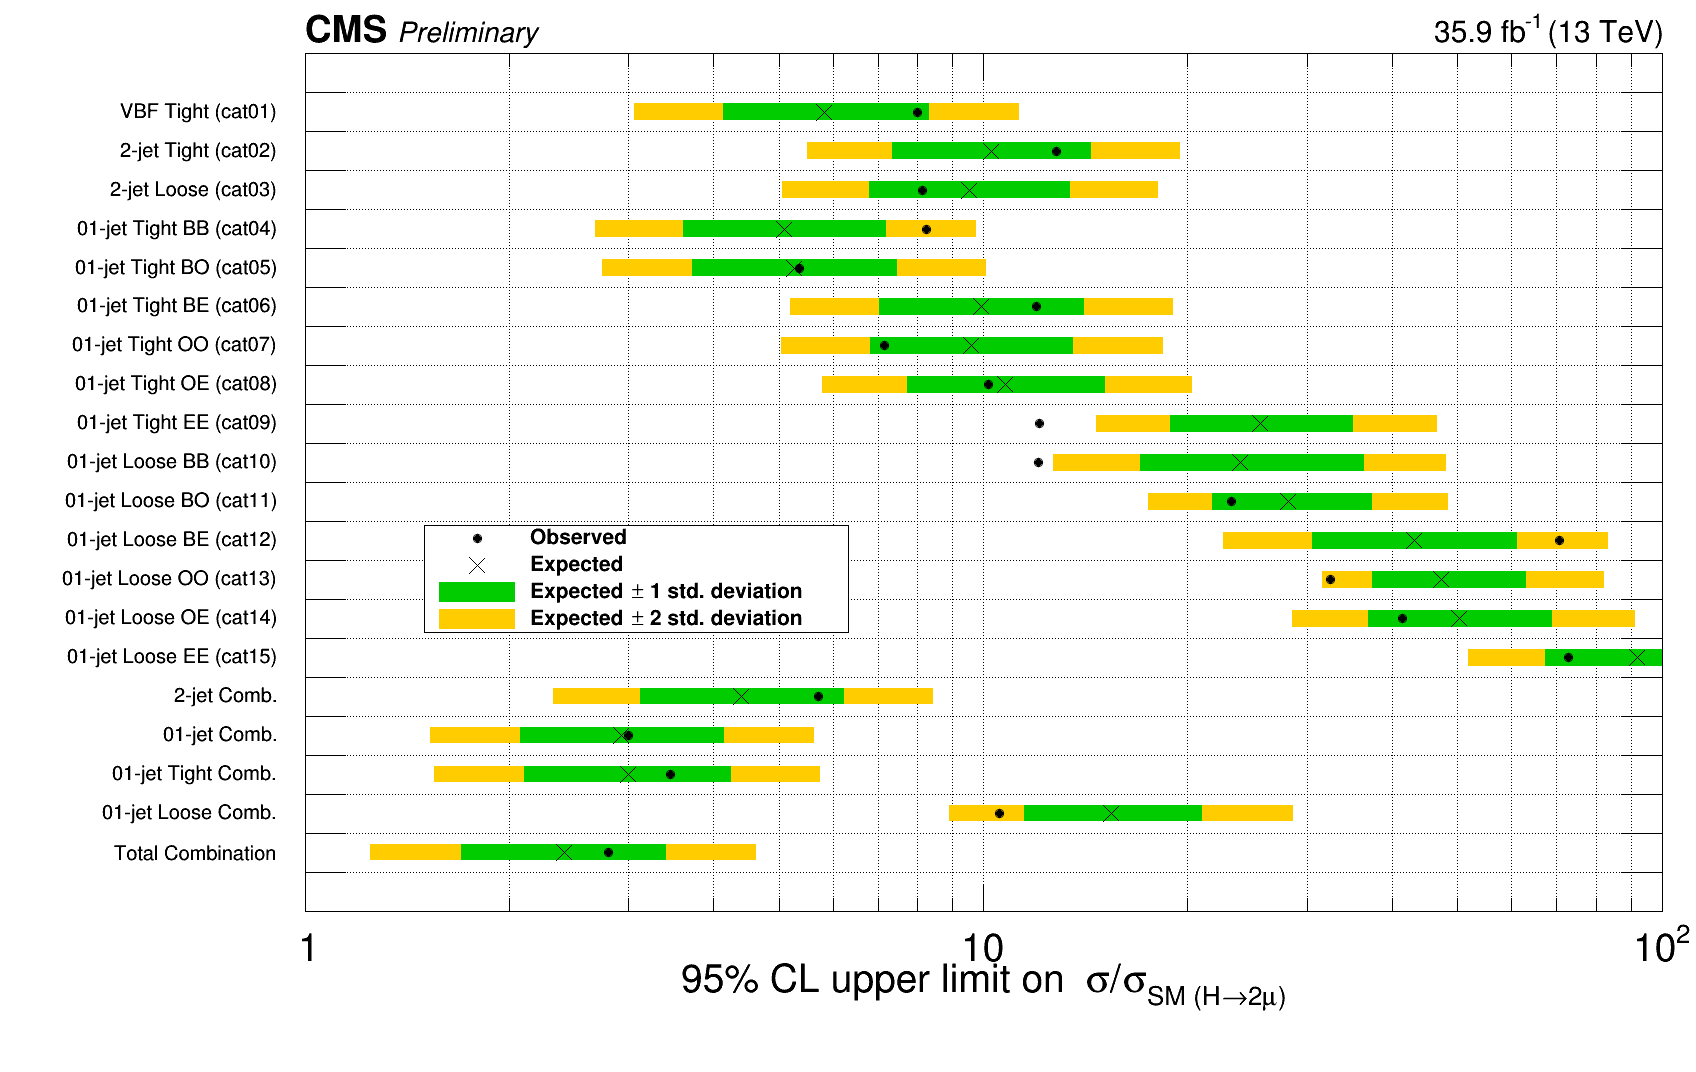

In [21]:
# dummy hist to set up margins, axes, etc.
frame = TH2D('catlims', 'catlims', int(xmax), 0., xmax, num_bins, 0, num_bins)
frame.Draw()
frame.GetXaxis().SetTitle('95% CL upper limit on '
                          '#sigma/#sigma_{SM (H#rightarrow2#mu)}')
frame.GetXaxis().SetTitleSize(.04)
frame.GetXaxis().SetTitleOffset(1.1)
frame.GetXaxis().CenterTitle(True)
frame.GetXaxis().SetLabelOffset(0.001)
frame.GetXaxis().SetRangeUser(0., xmax)
frame.GetYaxis().SetRangeUser(-0.5, ymax)
frame.GetYaxis().SetNdivisions(num_bins)
frame.GetXaxis().SetLabelSize(0.04)
frame.GetYaxis().SetLabelSize(0.03)
frame.GetYaxis().CenterLabels(True)

for i, n in enumerate(reversed(cat_names)):
    frame.GetYaxis().SetBinLabel(i+1, n)


# draw expected, 1 and 2 sigma band rectangles, and (if unblinded) observed
yellow.Draw('2')
green.Draw('2')
green.Draw('PX')
if not blind: money.Draw('P')

green.GetXaxis().SetRangeUser(0., xmax)

# create legend
leg = TLegend(leg_x1, leg_y1, leg_x2, leg_y2)
if not blind:
    leg.AddEntry(money, 'Observed', 'p')
leg.AddEntry(green, 'Expected', 'p')
leg.AddEntry(green, 'Expected #pm 1 std. deviation', 'F')
leg.AddEntry(yellow, 'Expected #pm 2 std. deviation', 'F')
leg.SetLineColor(kBlack)
leg.SetBorderSize(1)
leg.Draw()

canvas.Update()
if setlog:
    canvas.SetLogx()

# cms styling
period_int = 4
CMS_lumi.writeExtraText = isprelim
CMS_lumi.extraText = '    Preliminary'
CMS_lumi.lumi_13TeV = '%0.1f fb^{-1}' % (float(lumi)/1000.)
if lumi < 1000:
    CMS_lumi.lumi_13TeV = '%0.1f pb^{-1}' % (float(lumi))
CMS_lumi.CMS_lumi(canvas,period_int,lumipos);

canvas.Update()
canvas.Draw()

if printresults:
    for c in cats:
        print 
        print ' -- Asymptotic --', c
        print 'Observed Limit: r <', limits[c]['obs'], '+/-', limits[c]['obs_err']
        print 'Expected  2.5%: r <', limits[c]['2s_down']
        print 'Expected 16.0%: r <', limits[c]['1s_down']
        print 'Expected 50.0%: r <', limits[c]['median']
        print 'Expected 84.0%: r <', limits[c]['1s_up']
        print 'Expected 97.5%: r <', limits[c]['2s_up']